In [34]:
import os
import sys
sys.path.append('/zfsauton3/home/bparia/hf_moe/')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, minmax_scale
import pickle
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import networkx as nx

In [2]:
import tree

pkl_path = '../data/m5/data.pkl'
with open(pkl_path, 'rb') as fin:
    tree, ts_data, feats = pickle.load(fin)
# ts_means = np.mean(ts_data, axis=1).reshape((-1, 1))
# ts_data /= ts_means

# variations = ts_data[:, 1:] - ts_data[:, :-1]
# var2 = np.mean(np.abs(variations), axis=1)
# var1 = np.mean(variations**2, axis=1)
# var1 = np.sqrt(var1)
# ts_data = ts_data / var2.reshape((-1, 1))

# ts_data = ts_data[:, :-30]
# feats = feats[:, :-30]

# print(feats.shape, ts_data.shape)

1837 398


<ipython-input-158-1cff22b058e8>:7: RuntimeWarning: invalid value encountered in true_divide
  fracs = ts_data[:, children] / ts_data[:, idx].reshape((-1, 1))


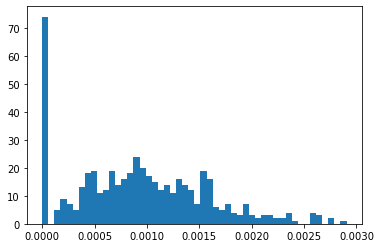

In [158]:
level = 1
idx = np.random.choice(tree.levels[level])
node_str = tree.id_node[idx]
children = tree.children[node_str]
children = [tree.node_id[c] for c in children]
print(idx, len(children))
fracs = ts_data[:, children] / ts_data[:, idx].reshape((-1, 1))

# mean_vals = np.nanmean(np.abs(fracs), axis=0, keepdims=True)
# fracs = fracs / mean_vals

plot_ids = range(fracs.shape[1])
if fracs.shape[1] > 1:
    plot_ids = np.random.choice(plot_ids, size=1, replace=False)

for i in plot_ids:
    plt.hist(fracs[-500:, i], bins=50)

# plt.ylim([0, 2])

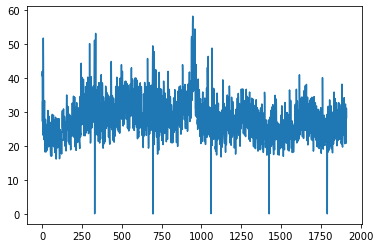

In [52]:
leaf_mat = tree.leaf_matrix.T
num_leaf = np.sum(leaf_mat, axis=0, keepdims=True)
ts_data_norm = ts_data / num_leaf

plt.plot(ts_data_norm.std(axis=1))

In [143]:
u, s, vh = np.linalg.svd(ts_data_norm.T, full_matrices=False)

In [73]:
'''
    U S V = M
    U satisfies the additivity property if rows of M satisfies the additivity property.
    This is also invariant to rotational transformations.
'''

leaf_mat = tree.leaf_matrix
mean_mat = leaf_mat / np.sum(leaf_mat, axis=1, keepdims=True)
diff = (mean_mat @ u) - u
np.mean(abs(diff))

6.500548e-12

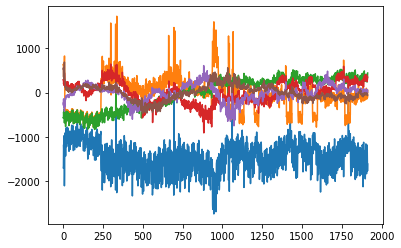

In [103]:
comps = s.reshape((-1, 1)) * vh
plt.plot(comps[0, :])
plt.plot(comps[1, :])
plt.plot(comps[2, :])
plt.plot(comps[3, :])
plt.plot(comps[4, :])
plt.plot(comps[5, :])

In [105]:
emb = TSNE(n_components=2).fit_transform(u[:, :5])

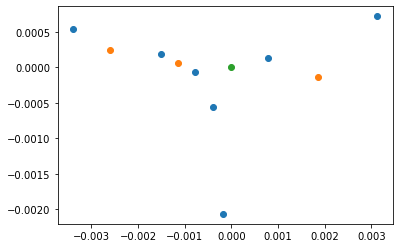

In [165]:
# emb = u[:, :20]
pca = PCA(n_components=2)
emb = pca.fit_transform(u[:, :10])
for d in range(2, -1, -1):
    idx = tree.levels[d]
    plt.scatter(emb[idx, 0], emb[idx, 1])

{0: array([0.5166053 , 0.69375736], dtype=float32), 1: array([0.19737664, 0.7652044 ], dtype=float32), 2: array([0.37563154, 0.711164  ], dtype=float32), 3: array([0.7448328, 0.6530123], dtype=float32), 4: array([0.1       , 0.84809935], dtype=float32), 5: array([0.469239  , 0.53337675], dtype=float32), 6: array([0.33195585, 0.745814  ], dtype=float32), 7: array([0.42074895, 0.6753706 ], dtype=float32), 8: array([0.6129286, 0.7309199], dtype=float32), 9: array([0.49555805, 0.1       ], dtype=float32), 10: array([0.90000004, 0.90000004], dtype=float32)}


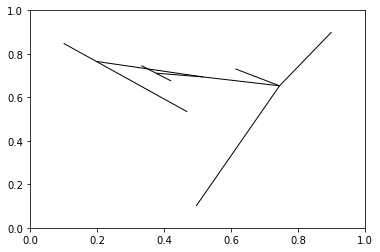

In [167]:
adj = tree.adj_matrix
sub_idx = tree.levels[0] + tree.levels[1] + tree.levels[2]
adj = adj[sub_idx, :]
adj = adj[:, sub_idx]

sub_emb = emb[sub_idx]

for i in range(2):
    mmin = np.min(sub_emb[:, i])
    mmax = np.max(sub_emb[:, i])
    sub_emb[:, i] = (sub_emb[:, i] - mmin)/(mmax - mmin) * 0.8 + 0.1

pos = {i:emb for i,emb in enumerate(sub_emb)}
print(pos)
G = nx.from_numpy_matrix(adj)
nx.draw_networkx_edges(G, pos=pos)
# nx.draw(G, with_labels=False, node_size=1)

In [55]:
pca = PCA(n_components=10)
pca.fit(ts_data_norm.T)

PCA(n_components=10)

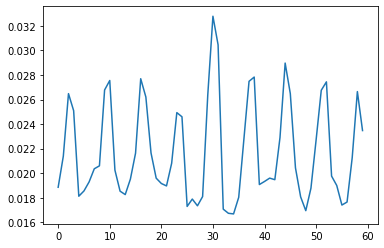

In [57]:
plt.plot(pca.components_[0, -60:])
# plt.plot(pca.mean_[-60:])

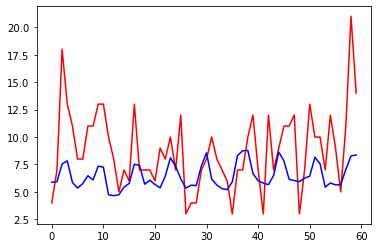

In [59]:
ncomp = 10
idx = np.random.choice(tree.levels[3])
x = ts_data_norm[:, idx:idx+1].T
xhat = np.dot(pca.transform(x)[:,:ncomp], pca.components_[:ncomp,:])
xhat += pca.mean_
xhat = xhat[0]
nts = 60
plt.plot(range(nts), x[0][-nts:], 'r')
plt.plot(range(nts), xhat[-nts:], 'b')

(array([446., 526., 388., 337., 234., 171., 208., 162.,  89., 107.,  91.,
         78.,  75.,  47.,  32.,  29.,  19.,   8.,   5.,   2.,   1.,   2.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.22934993, 0.2773038 , 0.32525772, 0.3732116 , 0.4211655 ,
        0.4691194 , 0.5170733 , 0.5650272 , 0.6129811 , 0.660935  ,
        0.7088889 , 0.75684273, 0.80479664, 0.85275054, 0.90070444,
        0.94865835, 0.9966122 , 1.0445662 , 1.09252   , 1.1404738 ,
        1.1884278 , 1.2363816 , 1.2843356 , 1.3322895 , 1.3802434 ,
        1.4281973 , 1.4761511 , 1.5241051 , 1.5720589 , 1.6200129 ,
        1.6679667 ], dtype=float32),
 <a list of 30 Patch objects>)

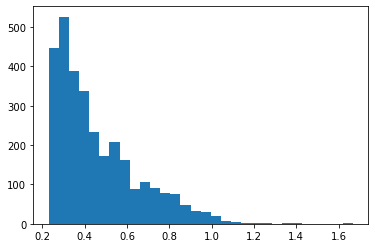

In [9]:
plt.hist(np.log(var1 / var2), bins=30)

1520


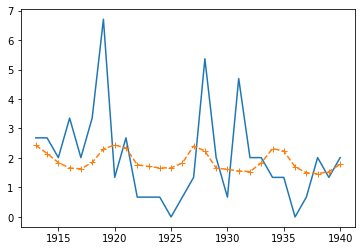

In [122]:
x = range(1941)
idx = np.random.choice(tree.levels[3])
print(idx)
plt.plot(x[-28:], ts_data[idx, -28:])
plt.plot(x[-28:], evals[-28:, idx], '+--')

In [3]:
file_path = '../data/m5/sales_train_evaluation.csv'
with open(file_path, 'r') as fin:
    sales_data = pd.read_csv(fin, ',')

In [4]:
agg = {}

for item in sales_data.itertuples():
    cat = item[3]
    vals = np.asarray(item[7:])
    agg[cat] = agg.get(cat, 0) + vals

print(agg.keys())

dict_keys(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3'])


1837


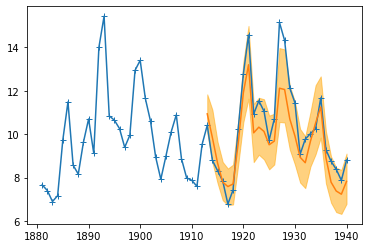

In [61]:
n = 60
x = range(1941)
for i in range(1):
    idx = np.random.choice(tree.levels[2])
    print(idx)
    y_ = ts_data[idx][-n:]
    y_pred = evals[:,:,idx]
    y_10p = np.percentile(y_pred, 10, axis=0)
    y_90p = np.percentile(y_pred, 90, axis=0)
    y_50p = np.percentile(y_pred, 50, axis=0)
    pred_hor = evals.shape[1]

    plt.plot(x[-n:], y_, '-+')
    plt.plot(x[-pred_hor:], y_50p)
    plt.fill_between(x[-pred_hor:], y_10p, y_90p, alpha=0.5, color='orange')
    

In [47]:
evals = np.load('evals.npy')
evals.shape

(1000, 28, 3060)

In [65]:
ratios

[0.3542659279778394]

In [5]:
sales_data

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [5]:
features_path = '../data/m5/calendar.csv'
with open(features_path, 'r') as fin:
    features = pd.read_csv(features_path, ',')

In [15]:
np.asarray(features[['wday', 'month', 'snap_CA', 'snap_TX', 'snap_WI']][:1941])

array([[1, 1, 0, 0, 0],
       [2, 1, 0, 0, 0],
       [3, 1, 0, 0, 0],
       ...,
       [7, 5, 0, 0, 0],
       [1, 5, 0, 0, 0],
       [2, 5, 0, 0, 0]])

In [64]:
feats_2 = features['event_type_1'][:1941]
cats = list(feats_2.unique())
cats.remove(np.nan)

feats_2 = [[''] if isinstance(f, float) else [f] for f in feats_2]
enc = OneHotEncoder(categories=[cats,], handle_unknown='ignore', sparse=False)
feats_2 = enc.fit_transform(feats_2)
print(feats_2[:30])

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [16]:
cat_feat_list = ['event_name_1', 'event_type_1']
cat_feats = []
cat_dims = []
for cat_feat_name in cat_feat_list:
    feats = features[cat_feat_name].fillna('')
    feats = [[feat] for feat in feats]
    enc = OrdinalEncoder(dtype=np.int32)
    feats = enc.fit_transform(feats)
    cat_feats.append(np.asarray(feats, dtype=np.float32))
    cat_dims.append(len(enc.categories_[0]))

In [20]:
features.iloc[:10]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [3]:
file_path = '../data/m5/sell_prices.csv'
with open(file_path, 'r') as fin:
    prices = pd.read_csv(fin, ',')


In [4]:
prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [14]:
p = [0.9, 0.05, 0.05]
l = [1, 2, 3]
sample = np.random.choice(l, size=2, replace=False, p=p)
print(sample)

[1 3]
